In [1]:
! pip install datasets
! pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [13]:
! pip uninstall transformer
! pip install --upgrade transformers

In [14]:
from google.colab import drive
import transformers
import pandas as pd
import numpy as np
import torch
import transformers
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset, ClassLabel
from evaluate import load
print(transformers.__version__)

4.51.3


In [3]:
drive.mount('/content/drive')

df = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/NLP/downsampled_data.csv",
    usecols=["Score", "Text"]
)
data = df[['Text', 'Score']].rename(columns={'Text':'review_text','Score':'star_rating'})
data['star_rating'] = data['star_rating'] - 1
def to_three(x):
  if x <= 1: return 0      # 1–2 stars → class 0
  if x == 2: return 1      # 3 stars   → class 1
  return 2                 # 4–5 stars → class 2

data['three_cls'] = data['star_rating'].map(to_three)
print(data.head())
print(data.tail())

Mounted at /content/drive
                                         review_text  star_rating  three_cls
0  I purchased this for the health benefits.  Unf...            0          0
1  I like the taste of this dressing, but realize...            0          0
2  Drink tasted like water...no chocolate taste a...            0          0
3  This tastes very sweet compared to other brand...            0          0
4  I ordered 3 jars of this calorie free Alfredo ...            0          0
                                            review_text  star_rating  \
9995  This is the best way to cook a roast.  Our loc...            4   
9996  Excellent product, slightly different than any...            4   
9997  My wife and I enjoy a pot of Green Chai Tea ea...            4   
9998  Our Yorkie loves this stuff. Our vet gave her ...            4   
9999  I've been on the auto ship with this item for ...            4   

      three_cls  
9995          2  
9996          2  
9997          2  
9998   

In [4]:
train_df, test_df = train_test_split(
        data,
        test_size=0.1,
        stratify=data['star_rating'],
        random_state=42
    )


# star_label = ClassLabel(num_classes=5, names=['1','2','3','4','5'])
# # change range from 1 to 5 to 0 to 4 for match classlabel
# train_ds = Dataset.from_pandas(train_df).cast_column('star_rating', star_label)
# test_ds  = Dataset.from_pandas(test_df).cast_column('star_rating', star_label)


star_label = ClassLabel(num_classes=3, names=['1','2','3'])
# change range from 1 to 5 to 0 to 4 for match classlabel
train_ds = Dataset.from_pandas(train_df).cast_column('three_cls', star_label)
test_ds  = Dataset.from_pandas(test_df).cast_column('three_cls', star_label)


train_ds = Dataset.from_pandas(train_df).rename_column('three_cls','labels')
test_ds  = Dataset.from_pandas(test_df).rename_column('three_cls','labels')
print(train_ds[0])
print(test_ds[0])

Casting the dataset:   0%|          | 0/9000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

{'review_text': "This tea was recommended to me to help slow my breast milk production.  I drank just one cup at night as I didn't want to over do it and dry up completely.  I didn't really notice any difference so for now I have stopped it all together.  The tea tastes fine, it just didn't work out for me.", 'star_rating': 2, 'labels': 1, '__index_level_0__': 5958}
{'review_text': "Of the 18 bars I got, five or six had dead spiders/webs on them INSIDE the wrappers, which were sealed and seemingly intact. Even if this isn't a frequently-ordered product, getting even one in such condition is inexcusable...not to mention gross!  Oskri, I hope you see this and correct the problem ASAP. I really liked this product...but I was so grossed out by the bugs, I can't possibly order it again!", 'star_rating': 1, 'labels': 0, '__index_level_0__': 2260}


In [5]:
# tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch['review_text'], truncation=True, max_length=512)

train_ds = train_ds.map(tokenize, batched=True)
test_ds  = test_ds.map(tokenize,  batched=True)

train_ds.set_format("torch", columns=["input_ids","attention_mask","labels"])
test_ds.set_format("torch", columns=["input_ids","attention_mask","labels"])

# train_ds = train_ds.remove_columns(['review_text', '__index_level_0__']).with_format('torch')
# test_ds  = test_ds.remove_columns (['review_text', '__index_level_0__']).with_format('torch')
print(train_ds[0])
print(test_ds[0])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

{'labels': tensor(1), 'input_ids': tensor([  101,  2023,  5572,  2001,  6749,  2000,  2033,  2000,  2393,  4030,
         2026,  7388,  6501,  2537,  1012,  1045, 10749,  2074,  2028,  2452,
         2012,  2305,  2004,  1045,  2134,  1005,  1056,  2215,  2000,  2058,
         2079,  2009,  1998,  4318,  2039,  3294,  1012,  1045,  2134,  1005,
         1056,  2428,  5060,  2151,  4489,  2061,  2005,  2085,  1045,  2031,
         3030,  2009,  2035,  2362,  1012,  1996,  5572, 16958,  2986,  1010,
         2009,  2074,  2134,  1005,  1056,  2147,  2041,  2005,  2033,  1012,
          102]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}
{'labels': tensor(0), 'input_ids': tensor([  101,  1997,  1996,  2324,  6963,  1045,  2288,  1010,  2274,  2030,
         2416,  2018,  2757, 141

In [6]:
# for padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


# model = DistilBertForSequenceClassification.from_pretrained(
#     'distilbert-base-uncased',
#     num_labels=5,
#     id2label={i: str(i+1) for i in range(5)},
#     label2id={str(i+1): i for i in range(5)}
# )
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
accuracy_metric = load('accuracy')
f1_metric = load('f1')

# f1 and accuracy evau
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc  = accuracy_metric.compute(predictions=preds, references=labels)['accuracy']
    f1   = f1_metric.compute(predictions=preds, references=labels, average='weighted')['f1']
    return {'accuracy': acc, 'f1': f1}

In [ ]:
training_args = TrainingArguments(
        output_dir = '/content/drive/MyDrive/Colab Notebooks/NLP/BERT3',
        learning_rate = 3e-5,
        per_device_train_batch_size = 36,
        per_device_eval_batch_size  = 16,
        num_train_epochs = 5,
        warmup_ratio = 0.1,
        weight_decay = 0.01,
        lr_scheduler_type = 'linear',
        report_to="none",           # turn *off* all loggers (including wandb)
        run_name=None,               # override the run name
        fp16                     = True,       # mixed‑precision
    )

trainer = Trainer(
    model           = model,
    args            = training_args,
    train_dataset   = train_ds,
    eval_dataset    = test_ds,
    data_collator   = data_collator,
    tokenizer       = tokenizer,
    compute_metrics = compute_metrics
)

<ipython-input-8-d3b8868dae70>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# train and eva
trainer.train()
trainer.evaluate()

Step,Training Loss
500,0.659300
1000,0.288000


{'eval_loss': 0.801573634147644,
 'eval_accuracy': 0.748,
 'eval_f1': 0.7524656628513535,
 'eval_runtime': 2.9061,
 'eval_samples_per_second': 344.107,
 'eval_steps_per_second': 21.679,
 'epoch': 5.0}

In [ ]:
trainer.save_model('/content/drive/MyDrive/Colab Notebooks/NLP/BERT3')
tokenizer.save_pretrained('/content/drive/MyDrive/Colab Notebooks/NLP/BERT3')

('/content/drive/MyDrive/Colab Notebooks/NLP/BERT3/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/NLP/BERT3/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/NLP/BERT3/vocab.txt',
 '/content/drive/MyDrive/Colab Notebooks/NLP/BERT3/added_tokens.json',
 '/content/drive/MyDrive/Colab Notebooks/NLP/BERT3/tokenizer.json')

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# 1. Run prediction on your test set
pred_out = trainer.predict(test_ds)
logits    = pred_out.predictions       # shape (N,5)
labels    = pred_out.label_ids         # ground‑truth 0–4

# 2. Convert logits → predicted class IDs
preds = np.argmax(logits, axis=-1)     # array of 0–4

# 3. Confusion matrix
cm = confusion_matrix(labels, preds)
print("Confusion Matrix (rows=true, cols=predicted):")
print(cm)

# 4. Classification report
#    Map your 0–4 back to “1”–“5” if you like:
target_names = [f"star_{i}" for i in range(1,6)]
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=target_names))

Confusion Matrix (rows=true, cols=predicted):
[[117  65  14   2   2]
 [ 35 111  40  10   4]
 [ 12  50 101  32   5]
 [  1   6  42 105  46]
 [  1   4  11  53 131]]

Classification Report:
              precision    recall  f1-score   support

      star_1       0.70      0.58      0.64       200
      star_2       0.47      0.56      0.51       200
      star_3       0.49      0.51      0.50       200
      star_4       0.52      0.53      0.52       200
      star_5       0.70      0.66      0.68       200

    accuracy                           0.56      1000
   macro avg       0.58      0.57      0.57      1000
weighted avg       0.58      0.56      0.57      1000



#Use saved model

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
os.environ["WANDB_DISABLED"] = "true"

In [22]:
save_path = "/content/drive/MyDrive/Colab Notebooks/NLP/BERT3"
tokenizer = AutoTokenizer.from_pretrained(save_path)
model = AutoModelForSequenceClassification.from_pretrained(save_path)

trainer = Trainer(model=model, tokenizer=tokenizer)

pred_output = trainer.predict(test_ds)
logits = pred_output.predictions      # shape (N_examples, num_labels)
y_pred = np.argmax(logits, axis=1)
y_true = pred_output.label_ids

# 4. Classification report
print(classification_report(y_true, y_pred, digits=4))

<ipython-input-22-4acc4badda70>:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


              precision    recall  f1-score   support

           0     0.8206    0.7775    0.7985       400
           1     0.4493    0.5100    0.4778       200
           2     0.8503    0.8375    0.8438       400

    accuracy                         0.7480      1000
   macro avg     0.7067    0.7083    0.7067      1000
weighted avg     0.7582    0.7480    0.7525      1000



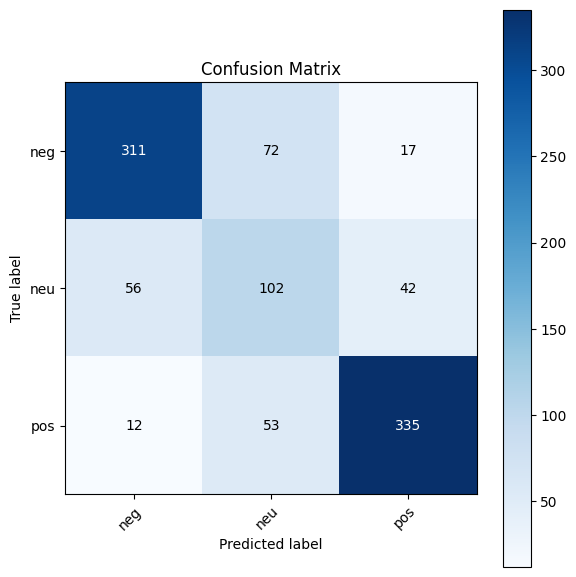

In [26]:
# 5. Confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = model.config.id2label.values()  # or supply your own list of class names

# 6. Plot
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')  # white→blue
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(labels)),
    yticks=np.arange(len(labels)),
    xticklabels=['neg', 'neu', 'pos'],
    yticklabels=['neg', 'neu', 'pos'],
    ylabel="True label",
    xlabel="Predicted label",
    title="Confusion Matrix",
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# annotate counts in the matrix
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()